> # IT공학과 2214224 서지은

---


# 실습 과제 1

본인의 이미지 2장을 이용하여 optical flow 그리세요.

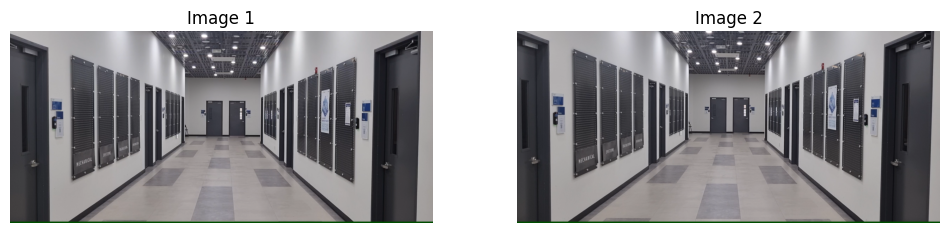

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL
url1 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000001.png?raw=true"
url2 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000007.png?raw=true"

# 이미지를 불러오는 함수
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# 이미지를 불러오기
img1 = load_image(url1)
img2 = load_image(url2)

# 이미지를 PyTorch 텐서로 변환
transform = transforms.ToTensor()
img1_tensor = transform(img1)
img2_tensor = transform(img2)

# 이미지를 1열 2열로 imshow로 표시
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img1_tensor.permute(1, 2, 0))
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(img2_tensor.permute(1, 2, 0))
axs[1].set_title('Image 2')
axs[1].axis('off')

plt.show()


Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth
100%|██████████| 20.1M/20.1M [00:00<00:00, 143MB/s]


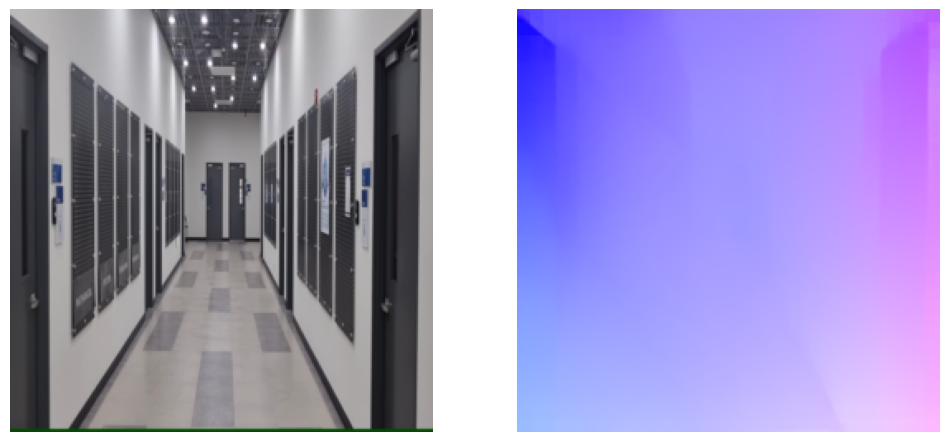

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np

# 이미지 URL
url1 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000001.png?raw=true"
url2 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000007.png?raw=true"

# 이미지를 불러오는 함수
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# 이미지를 불러오기
img1 = load_image(url1)
img2 = load_image(url2)

# 이미지를 PyTorch 텐서로 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # 모델 입력 크기에 맞게 조정
])
img1_tensor = transform(img1).unsqueeze(0)
img2_tensor = transform(img2).unsqueeze(0)

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RAFT 모델 로드
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

weights = Raft_Large_Weights.C_T_SKHT_V2
model = raft_large(weights=weights).to(device)
model = model.eval()

# 이미지 배치 생성
img1_batch = img1_tensor.to(device)
img2_batch = img2_tensor.to(device)

# Optical Flow 계산
with torch.no_grad():
    list_of_flows = model(img1_batch, img2_batch)

predicted_flows = list_of_flows[-1]

# Optical Flow 이미지를 변환
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# 결과 시각화
def plot(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 6))
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# 원래 이미지와 Optical Flow 이미지 그리드 생성 및 시각화
plot([img1_tensor[0], flow_imgs[0].cpu()])


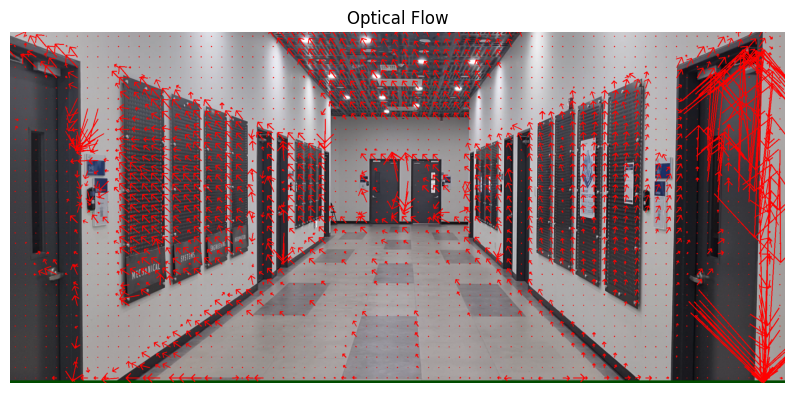

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np
import cv2

# 이미지 URL
url1 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000001.png?raw=true"
url2 = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/frame000007.png?raw=true"

# 이미지를 불러오는 함수
def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# 이미지를 불러오기
img1 = load_image(url1)
img2 = load_image(url2)

# 이미지를 numpy array로 변환
img1_np = np.array(img1)
img2_np = np.array(img2)

# Optical Flow 계산
gray1 = cv2.cvtColor(img1_np, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2_np, cv2.COLOR_RGB2GRAY)
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

def draw_flow(img, flow, step=512):
    """Draws optical flow arrows on the image."""
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    # Create a new image to draw on
    vis = img.copy()

    # Draw the flow vectors
    for (x, y, fx, fy) in zip(x, y, fx, fy):
        cv2.arrowedLine(vis, (x, y), (int(x+fx), int(y+fy)), (255, 0, 0), 2, tipLength=0.5)

    return vis

# Optical Flow 시각화
flow_img = draw_flow(img1_np, flow, step=32)

# 결과 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(flow_img)
plt.title('Optical Flow')
plt.axis('off')
plt.show()


# 실습 과제 2

본인의 pose sequence 데이터를 이용하여 순차적인 10개의 pose를 이용해
다음 3개의 pose를 예측하는 LSTM 모델을 학습시키고 결과를 논의하세요.

<ipython-input-30-2a27bd5d76bb>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


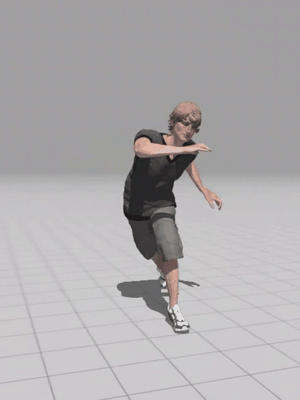

In [ ]:
import requests
from PIL import Image, ImageSequence
from io import BytesIO
import matplotlib.pyplot as plt

# 이미지 파일 번호 목록 생성
image_numbers = range(1, 21)  # 1부터 20까지

# 이미지를 리스트로 저장
images = []

# 이미지의 크기를 조정할 함수
def resize_image(image, size=(300, 400)):
    return image.resize(size, Image.ANTIALIAS)

for num in image_numbers:
    url = f"https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/u{num}.jpg?raw=true"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_resized = resize_image(img)  # 이미지 크기 조정
    images.append(img_resized)

# 첫 번째 이미지를 기준으로 GIF 생성
images[0].save('output_resized.gif', save_all=True, append_images=images[1:], duration=500, loop=0)

# GIF 확인을 위해 Colab 노트북에 표시
from IPython.display import Image as IPImage
from IPython.display import display

display(IPImage(filename='output_resized.gif'))


<ipython-input-31-308cb390d320>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 121MB/s]


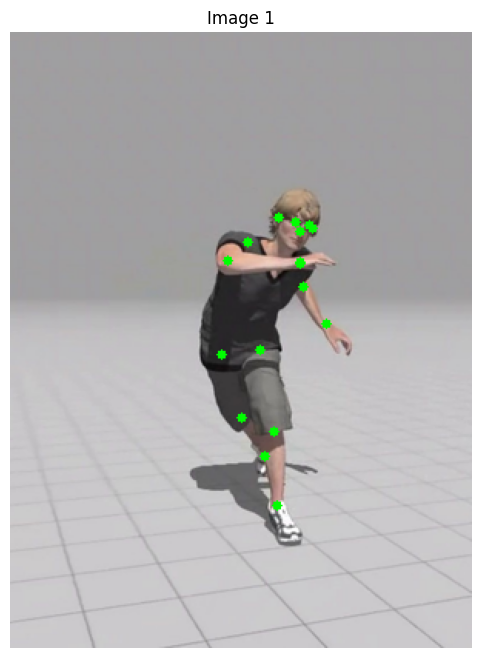

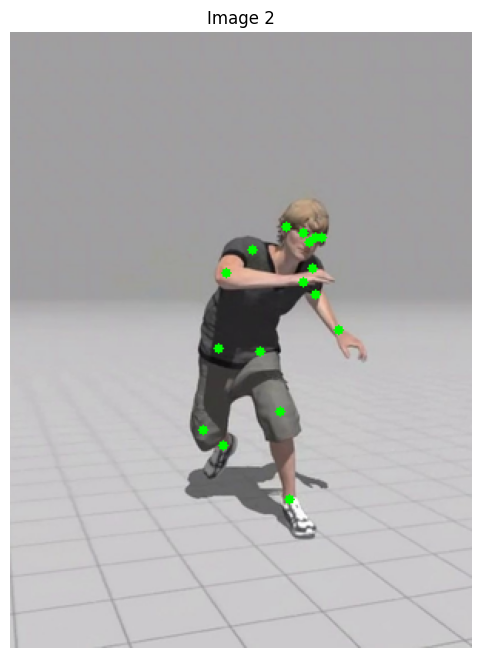

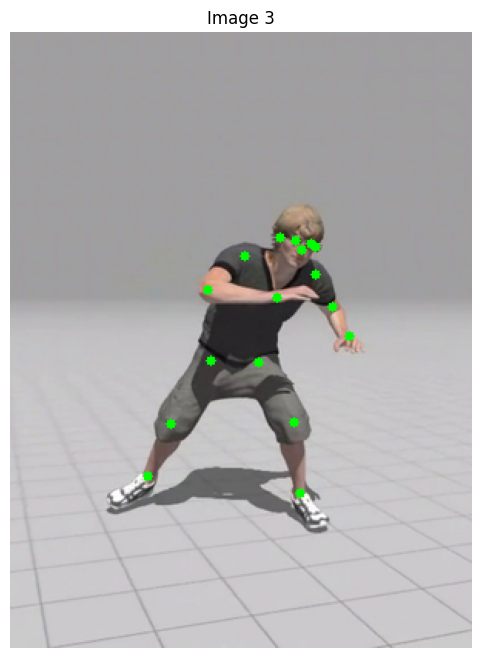

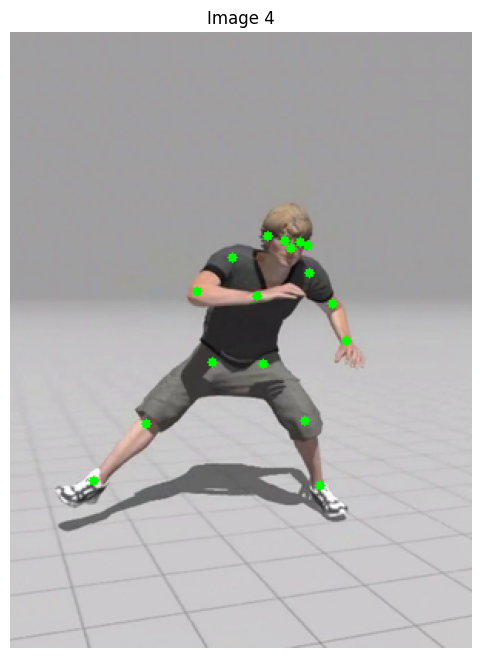

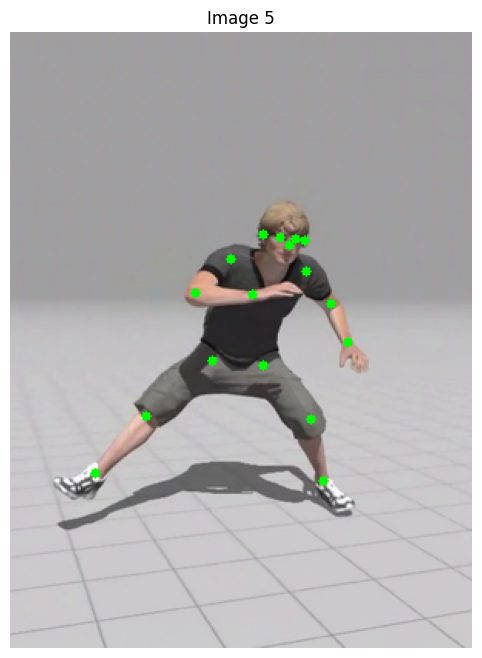

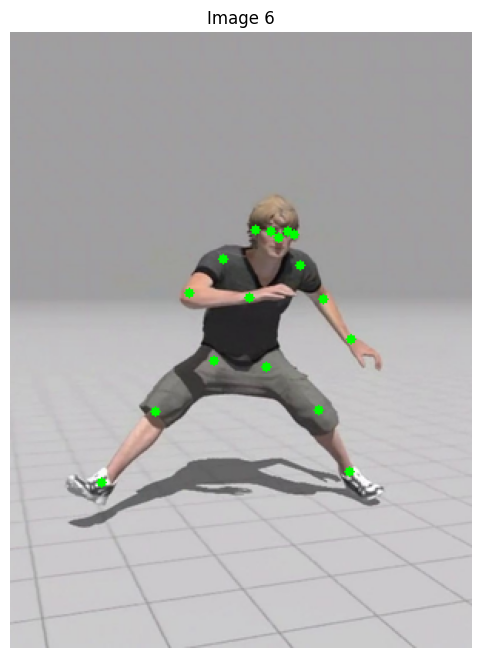

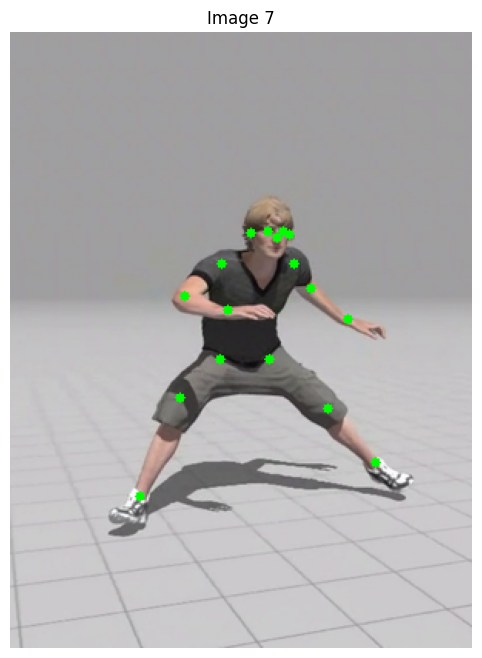

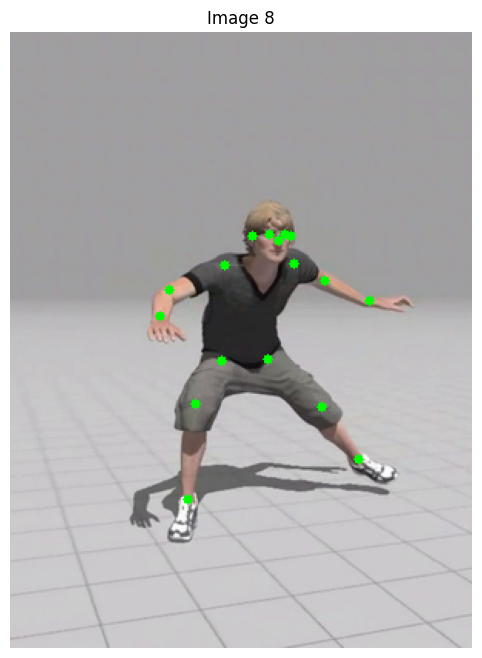

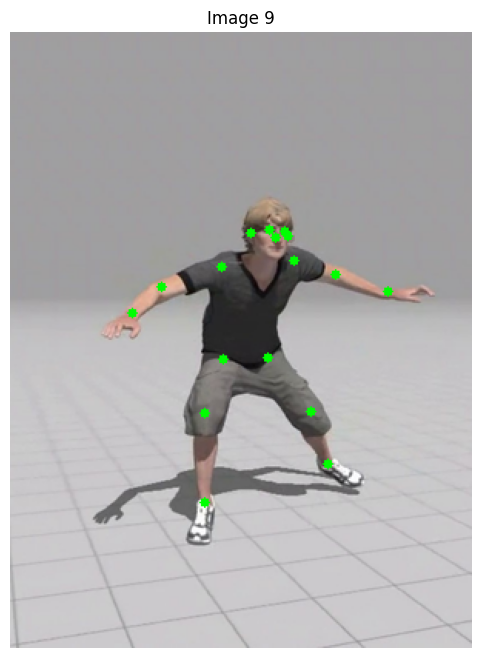

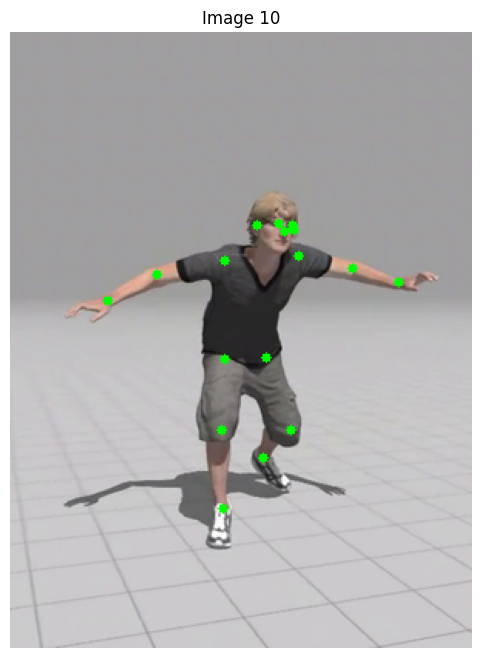

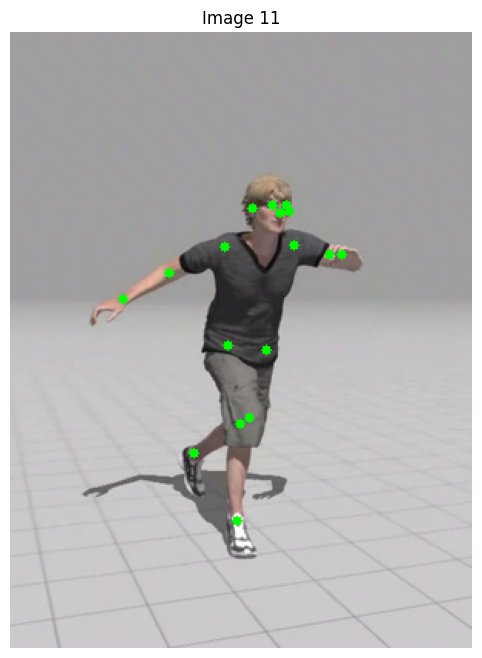

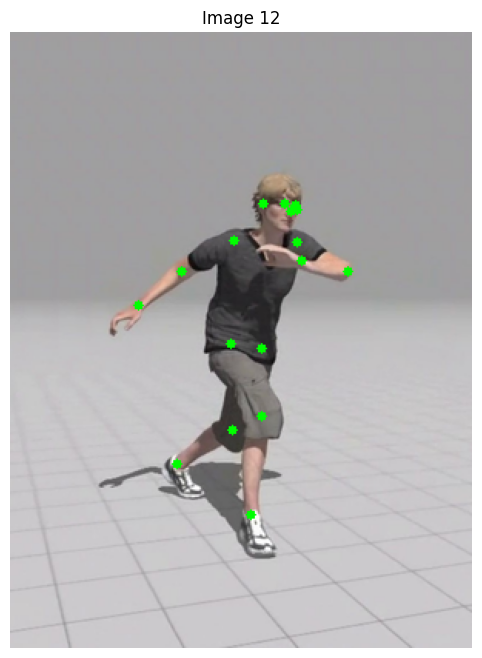

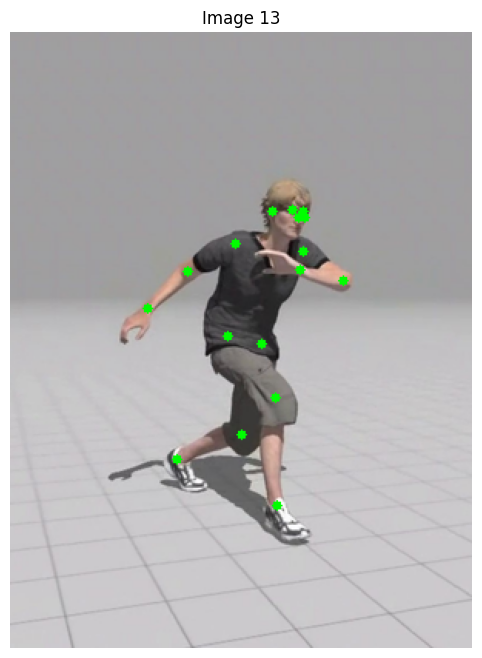

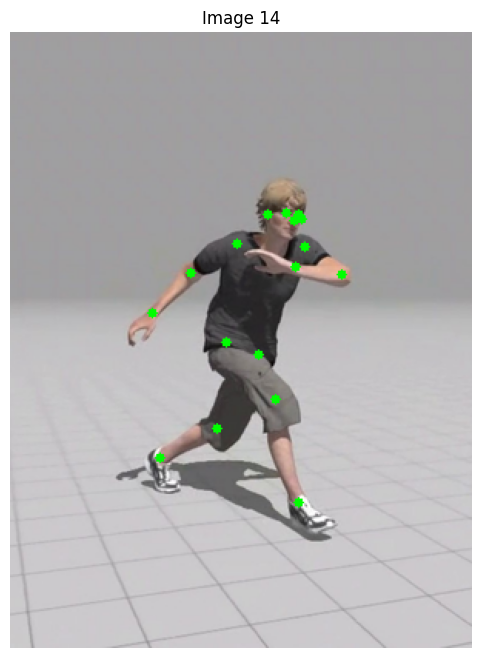

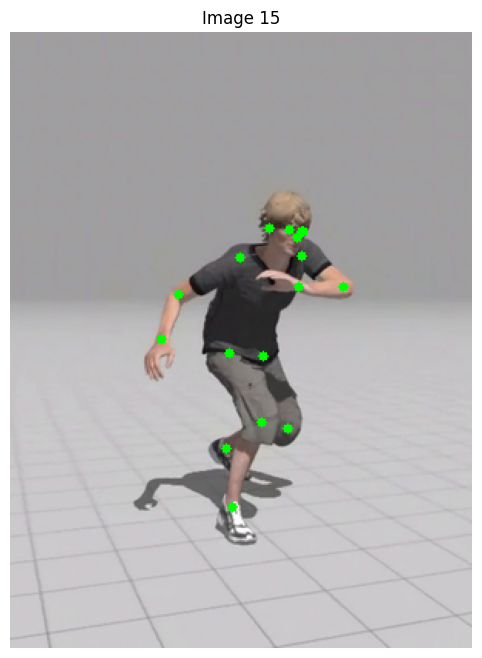

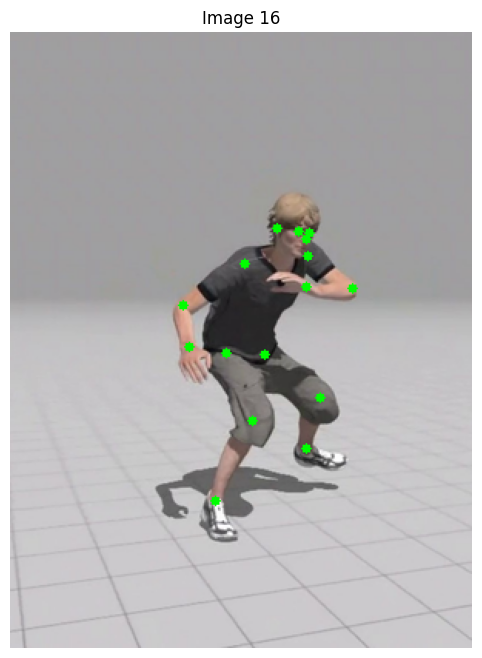

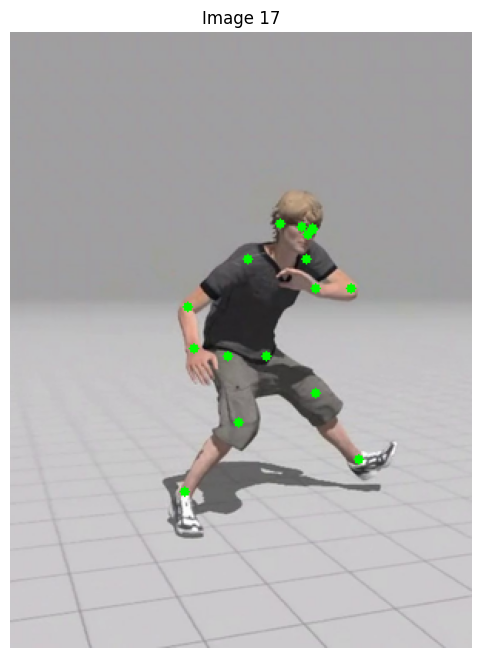

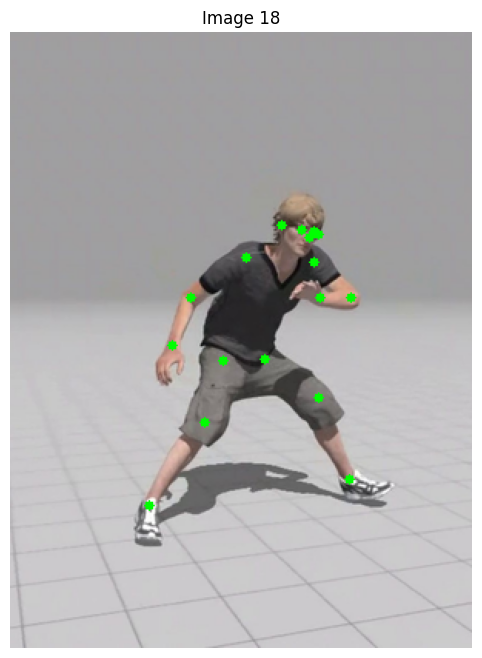

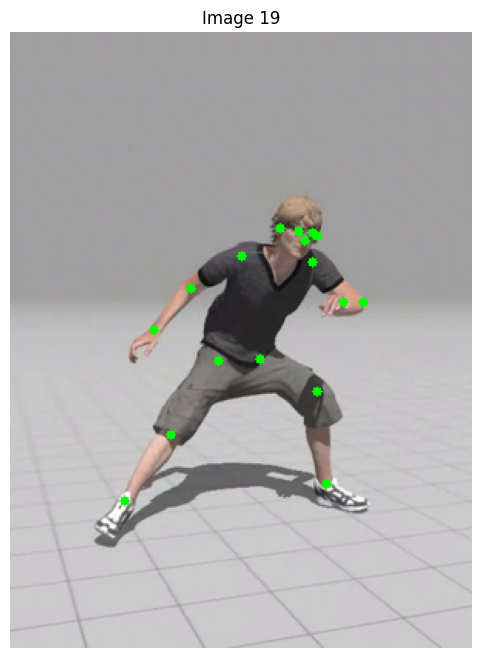

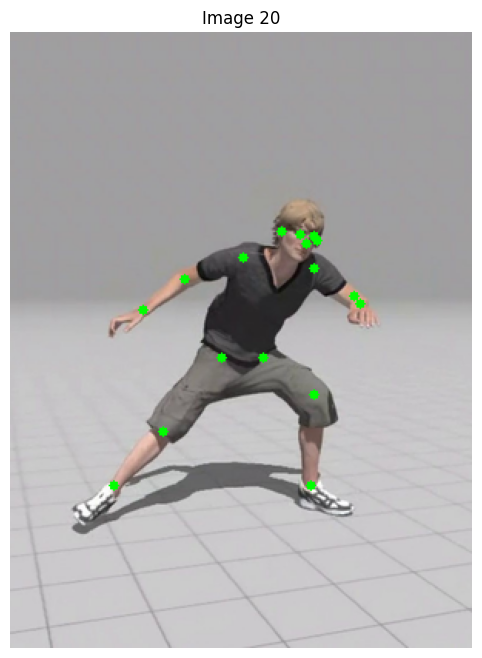

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 파일 번호 목록 생성
image_numbers = range(1, 21)  # 1부터 20까지

# 이미지를 리스트로 저장
images = []

def resize_image(image, size=(300, 400)):
    return image.resize(size, Image.ANTIALIAS)

for num in image_numbers:
    url = f"https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/u{num}.jpg?raw=true"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_resized = resize_image(img)  # 이미지 크기 조정
    images.append(img_resized)

# Load a pre-trained pose estimation model from torchvision
# For this example, we use a pre-trained Keypoint R-CNN
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

def get_keypoints(image, model):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image_tensor)

    keypoints = output[0]['keypoints'][0].cpu().numpy()
    return keypoints

def draw_keypoints(image, keypoints):
    image = np.array(image)
    for keypoint in keypoints:
        cv2.circle(image, (int(keypoint[0]), int(keypoint[1])), 3, (0, 255, 0), -1)
    return image

for i, img in enumerate(images):
    keypoints = get_keypoints(img, model)
    img_with_keypoints = draw_keypoints(img, keypoints)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_keypoints)
    plt.title(f'Image {i+1}')
    plt.axis('off')
    plt.show()

Epoch [10/100], Loss: 0.0843
Epoch [20/100], Loss: 0.0297
Epoch [30/100], Loss: 0.0097
Epoch [40/100], Loss: 0.0046
Epoch [50/100], Loss: 0.0034
Epoch [60/100], Loss: 0.0034
Epoch [70/100], Loss: 0.0034
Epoch [80/100], Loss: 0.0032
Epoch [90/100], Loss: 0.0032
Epoch [100/100], Loss: 0.0032


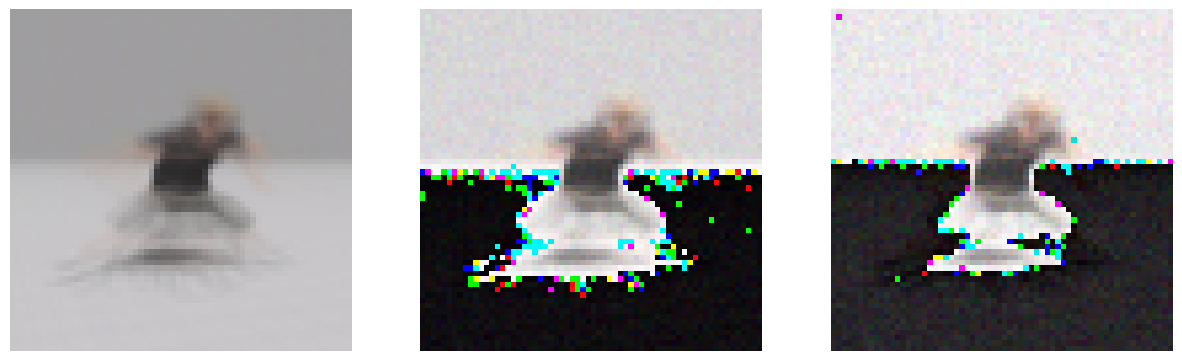

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# URL 리스트 생성
base_url = "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/u"
image_urls = [f"{base_url}{i}.jpg?raw=true" for i in range(1, 21)]

# 이미지 다운로드 및 전처리
def load_images(image_urls):
    images = []
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    for url in image_urls:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = transform(img)
        images.append(img)
    return torch.stack(images)

images = load_images(image_urls)

# LSTM 모델 정의
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

# 모델 하이퍼파라미터 설정
input_size = 64 * 64 * 3
hidden_size = 512
num_layers = 2
output_size = input_size
num_epochs = 100
learning_rate = 0.001

# 모델, 손실 함수 및 옵티마이저 초기화
model = LSTMGenerator(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 데이터 준비
train_data = images.view(-1, 1, input_size)  # (batch_size, seq_len, input_size)

# 모델 학습
for epoch in range(num_epochs):
    hidden = (torch.zeros(num_layers, train_data.size(0), hidden_size),
              torch.zeros(num_layers, train_data.size(0), hidden_size))

    outputs, hidden = model(train_data, hidden)
    loss = criterion(outputs, train_data.view(-1, input_size))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 새로운 이미지 생성
model.eval()
with torch.no_grad():
    hidden = (torch.zeros(num_layers, 1, hidden_size),
              torch.zeros(num_layers, 1, hidden_size))
    generated_images = []
    input_image = train_data[-1].unsqueeze(0)  # 마지막 학습 이미지로 초기화
    for _ in range(3):  # 3개의 새로운 이미지 생성
        output, hidden = model(input_image, hidden)
        generated_image = output.view(3, 64, 64).permute(1, 2, 0).numpy()
        generated_images.append(generated_image)
        input_image = output.unsqueeze(0)

# 생성된 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, gen_img in enumerate(generated_images):
    axes[i].imshow((gen_img * 255).astype(np.uint8))
    axes[i].axis('off')
plt.show()


# 실습 과제 3

Lab7에서 사용한 Depth Data를 이용하여 MiDAS 모델의 Depth Estimation
을 수행하세요

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

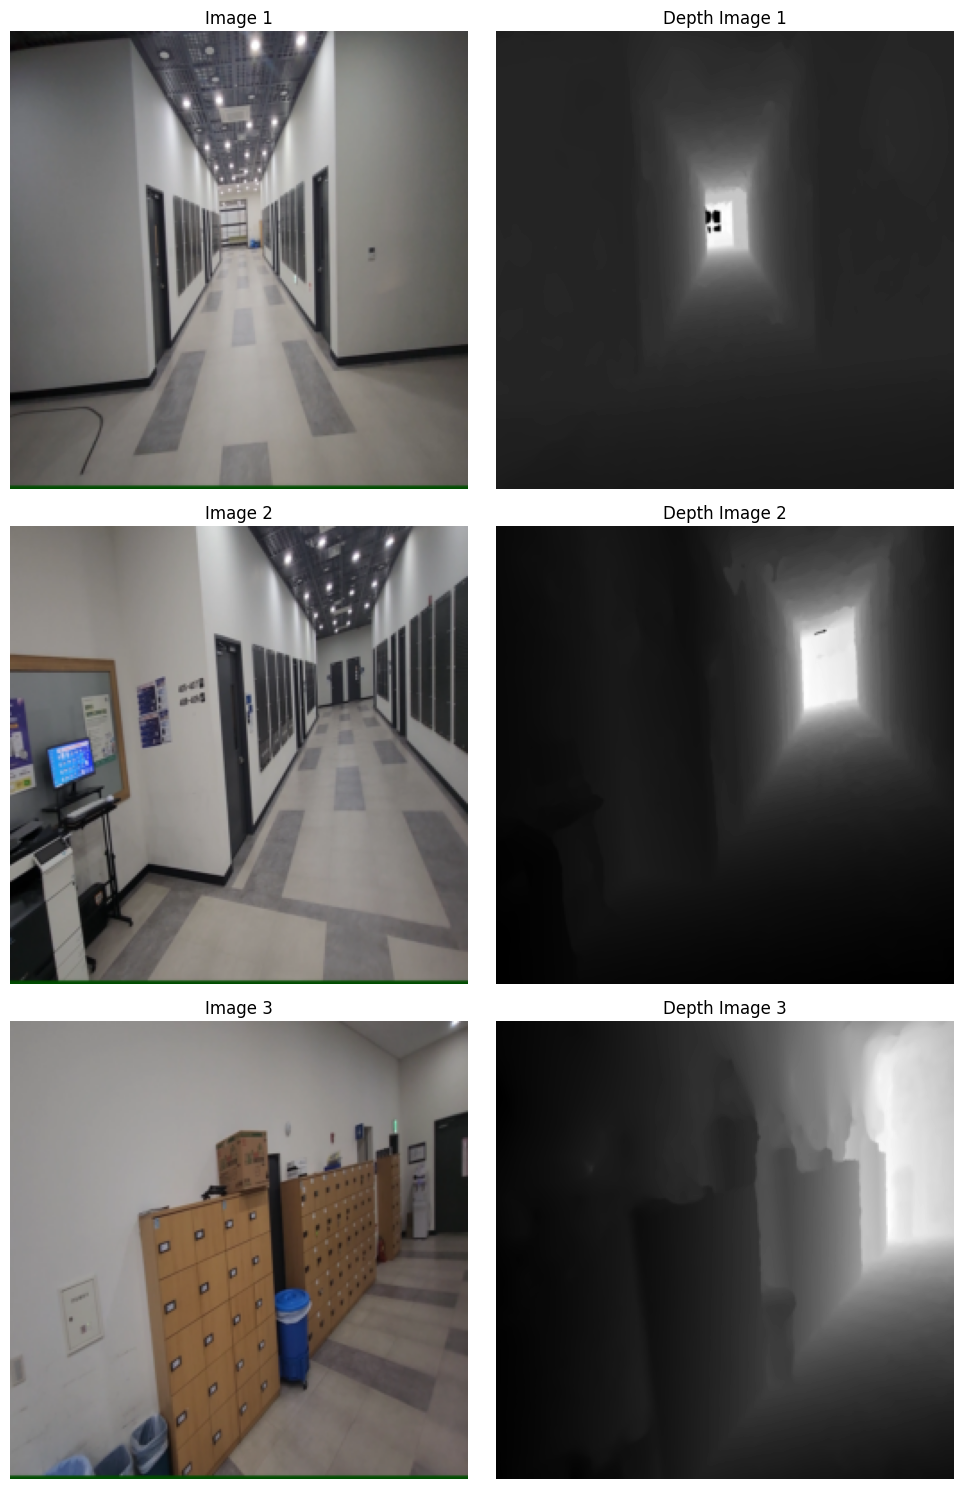

In [ ]:
# 필요한 라이브러리 설치 및 임포트
!pip install opencv-python-headless pillow

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io

def load_image_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    return np.array(image)

# 이미지와 Depth 이미지 URL
image_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000135.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000520.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000990.png?raw=true"
]

depth_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000135.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000520.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000990.png.depth.exr.tiff?raw=true"
]

# 이미지와 Depth 이미지 불러오기
images = [load_image_from_github(url) for url in image_urls]
depth_images = [load_image_from_github(url) for url in depth_urls]

# 이미지와 Depth 이미지 표시
fig, axes = plt.subplots(len(images), 2, figsize=(10, 15))

for i in range(len(images)):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_images[i], cmap='gray')
    axes[i, 1].set_title(f"Depth Image {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


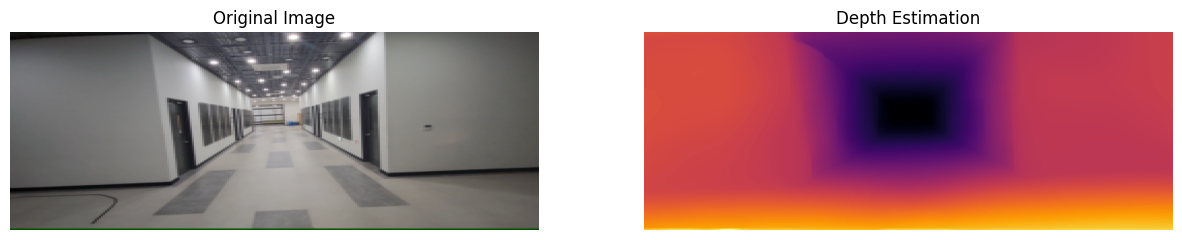

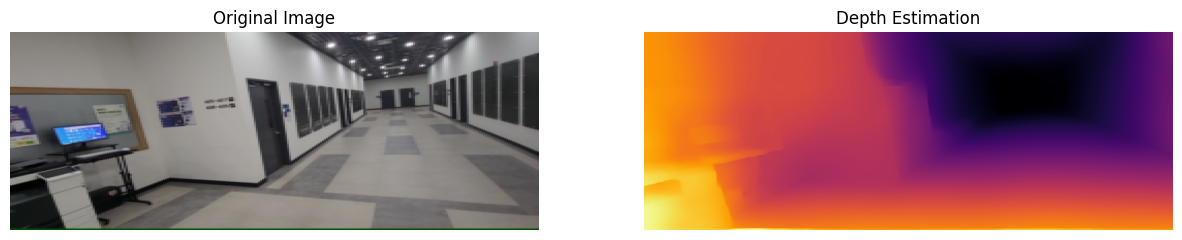

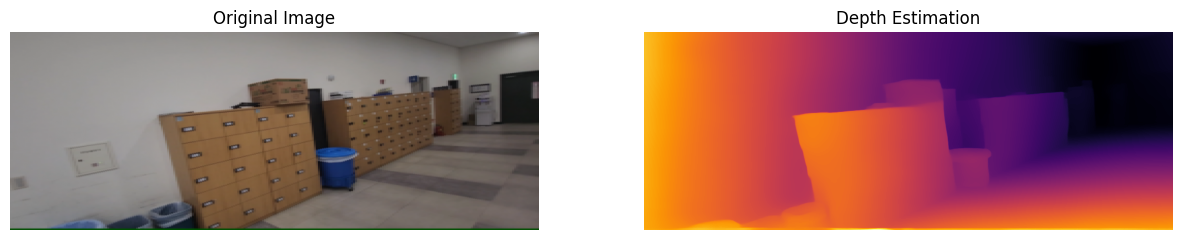

In [ ]:
# 필요한 라이브러리 설치 및 임포트
!pip install opencv-python-headless pillow torch torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
import torch
import torchvision.transforms as T

# 이미지 URL
image_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000135.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000520.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000990.png?raw=true"
]


depth_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000135.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000520.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000990.png.depth.exr.tiff?raw=true"
]



# 이미지 불러오기
def load_image_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert('RGB')
    return image

images = [load_image_from_github(url) for url in image_urls]

# Midas 모델 불러오기
model_type = "DPT_Large"  # 모델 타입 설정
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# 이미지와 Depth 이미지 추정 결과 표시
for img in images:
    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(img) / 255.0  # 이미지를 0-1 사이로 정규화

    # 변환 과정 수동으로 구현
    img_resized = cv2.resize(img_np, (1024, 384), interpolation=cv2.INTER_AREA)
    img_transformed = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 깊이 추정 수행
    with torch.no_grad():
        depth_map = midas(img_transformed)

    # 결과를 numpy 배열로 변환
    depth_map = depth_map.squeeze().cpu().numpy()

    # 깊이 맵을 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(img_resized)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(depth_map, cmap='inferno')
    axes[1].set_title('Depth Estimation')
    axes[1].axis('off')

    plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


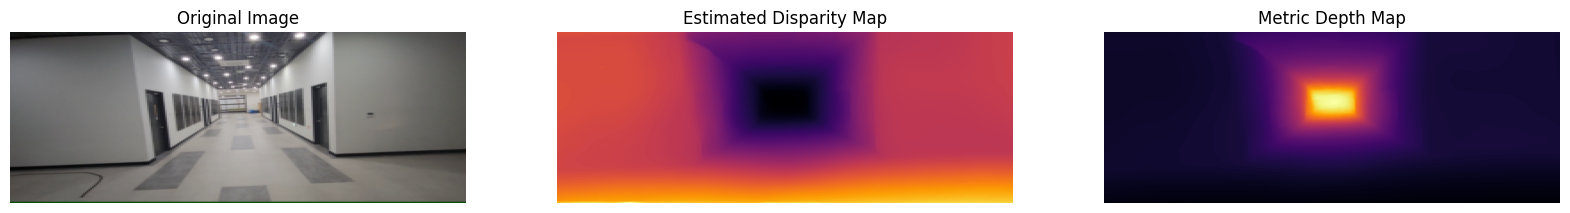

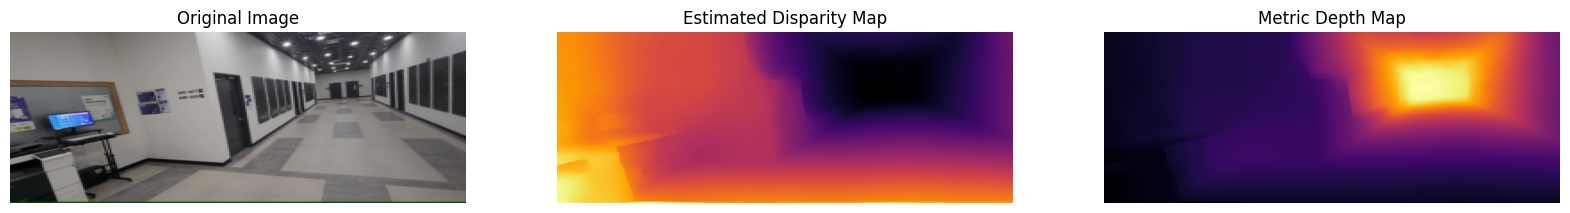

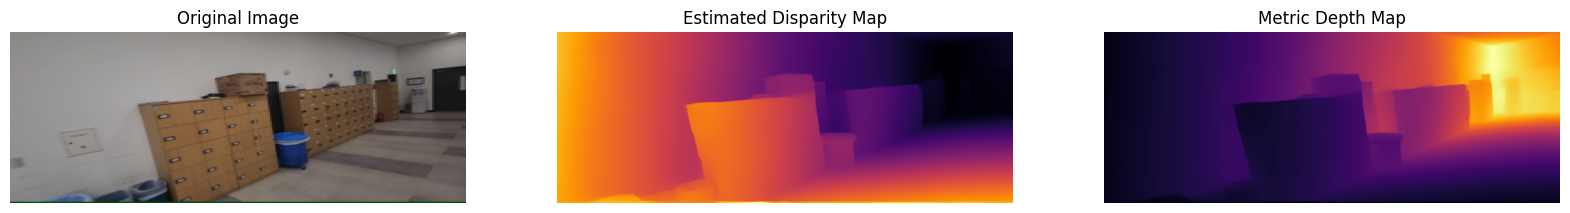

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
import torch

# 이미지 URL
image_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000135.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000520.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000990.png?raw=true"
]

depth_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000135.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000520.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000990.png.depth.exr.tiff?raw=true"
]

# 이미지 불러오기
def load_image_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert('RGB')
    return image

# TIFF 파일 불러오기
def load_tiff_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    return np.array(image)

images = [load_image_from_github(url) for url in image_urls]
depths = [load_tiff_from_github(url) for url in depth_urls]

# Midas 모델 불러오기
model_type = "DPT_Large"  # 모델 타입 설정
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# Disparity Map을 Metric Depth Map으로 변환하는 함수
def disparity_to_depth(disparity, scale, shift):
    return 1.0 / (disparity * scale + shift)

# 이미지와 Depth 이미지 추정 결과 표시
for img, gt_depth in zip(images, depths):
    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(img) / 255.0  # 이미지를 0-1 사이로 정규화

    # 변환 과정 수동으로 구현
    img_resized = cv2.resize(img_np, (1024, 384), interpolation=cv2.INTER_AREA)
    img_transformed = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 깊이 추정 수행
    with torch.no_grad():
        depth_map = midas(img_transformed)

    # 결과를 numpy 배열로 변환
    depth_map = depth_map.squeeze().cpu().numpy()

    # Ground Truth와 MiDAS Depth Map 스케일링
    gt_depth_resized = cv2.resize(gt_depth, (1024, 384), interpolation=cv2.INTER_AREA)
    gt_depth_resized = gt_depth_resized / np.max(gt_depth_resized)

    # 최소 자승법으로 스케일과 오프셋 찾기
    valid_mask = (depth_map > 0) & (gt_depth_resized > 0)
    A = np.vstack([depth_map[valid_mask], np.ones(len(depth_map[valid_mask]))]).T
    scale, shift = np.linalg.lstsq(A, 1.0 / gt_depth_resized[valid_mask], rcond=None)[0]

    # Metric Depth Map 생성
    metric_depth_map = disparity_to_depth(depth_map, scale, shift)

    # 깊이 맵을 시각화
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    axes[0].imshow(img_resized)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(depth_map, cmap='inferno')
    axes[1].set_title('Estimated Disparity Map')
    axes[1].axis('off')

    axes[2].imshow(metric_depth_map, cmap='inferno')
    axes[2].set_title('Metric Depth Map')
    axes[2].axis('off')

    plt.show()


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


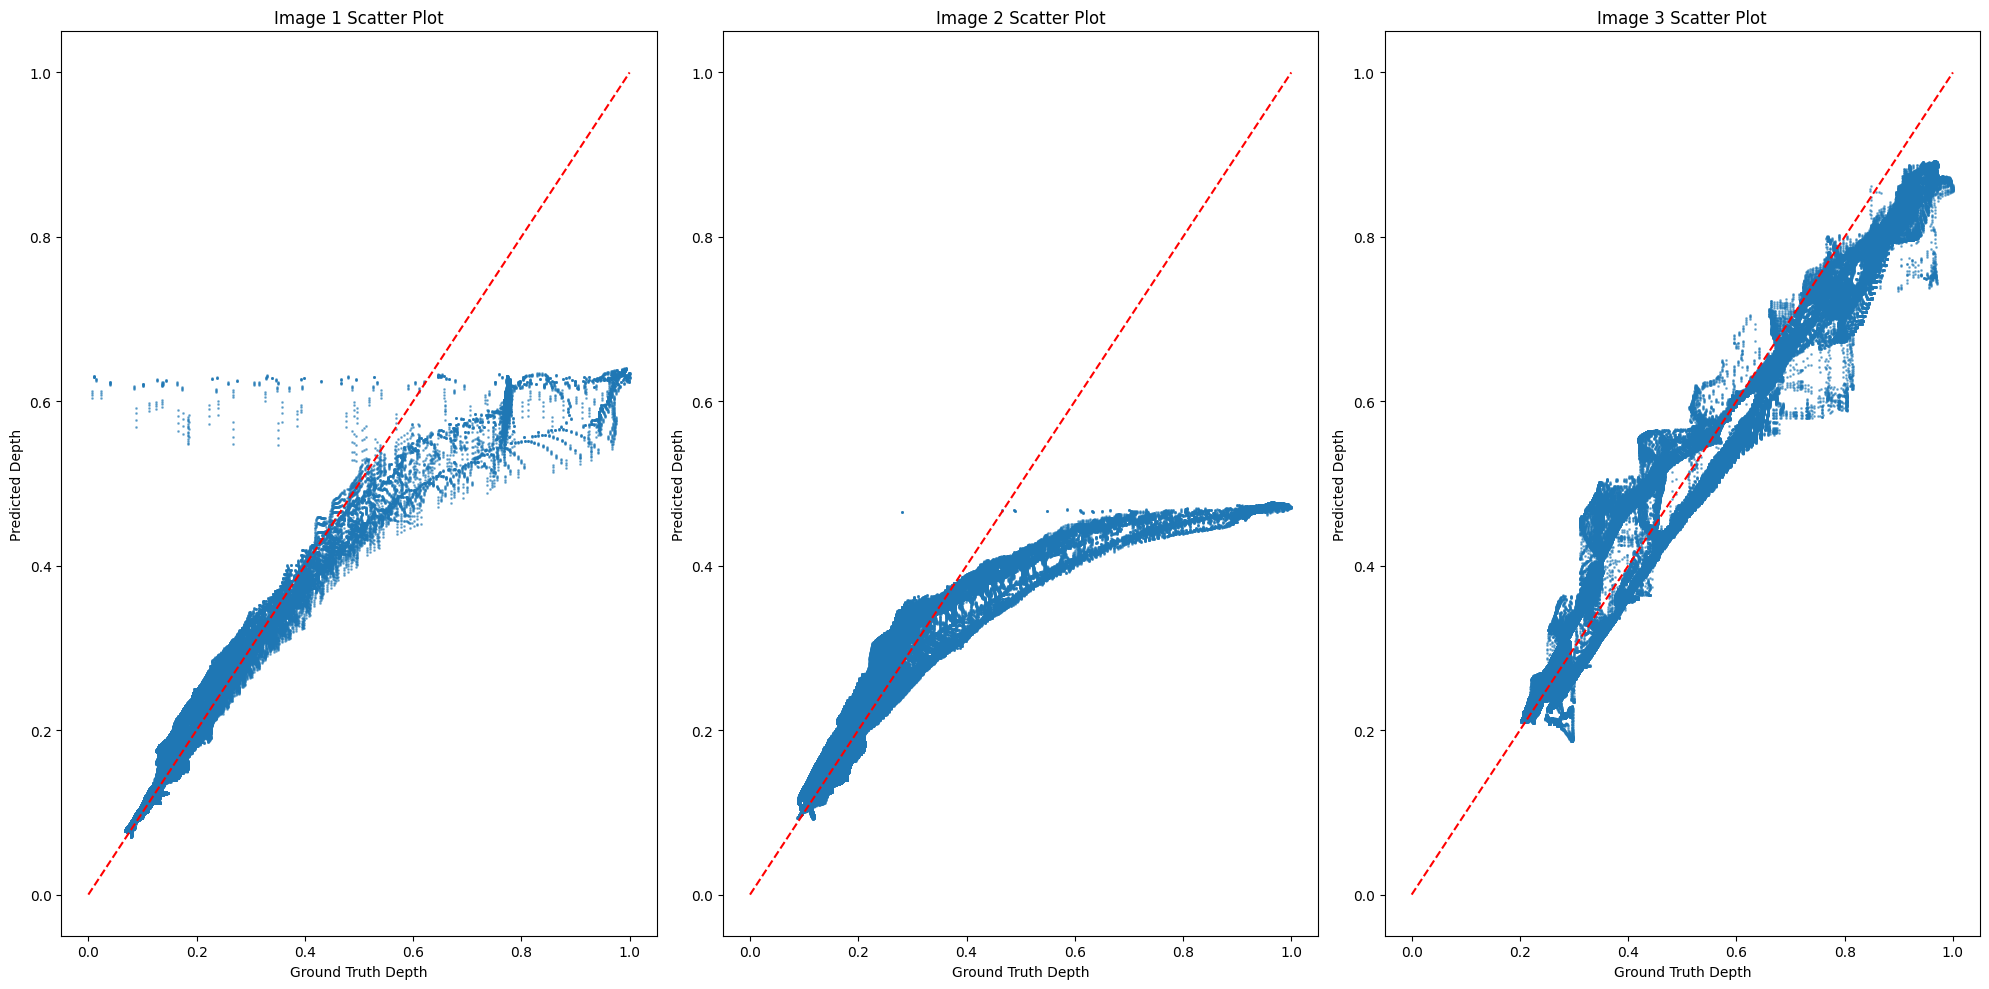

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
import torch

# 이미지 URL
image_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000135.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000520.png?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/rgb_frame000990.png?raw=true"
]

depth_urls = [
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000135.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000520.png.depth.exr.tiff?raw=true",
    "https://github.com/Nick-Stokes/DLHW/blob/main/HW3_img/depth_20240501_184023.mp4_frame000990.png.depth.exr.tiff?raw=true"
]

# 이미지 불러오기
def load_image_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert('RGB')
    return image

# TIFF 파일 불러오기
def load_tiff_from_github(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    return np.array(image)

images = [load_image_from_github(url) for url in image_urls]
depths = [load_tiff_from_github(url) for url in depth_urls]

# Midas 모델 불러오기
model_type = "DPT_Large"  # 모델 타입 설정
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# Disparity Map을 Metric Depth Map으로 변환하는 함수
def disparity_to_depth(disparity, scale, shift):
    return 1.0 / (disparity * scale + shift)

# 각 이미지에 대해 처리
metric_depth_maps = []
gt_depths_resized = []

for img, gt_depth in zip(images, depths):
    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(img) / 255.0  # 이미지를 0-1 사이로 정규화

    # 변환 과정 수동으로 구현
    img_resized = cv2.resize(img_np, (1024, 384), interpolation=cv2.INTER_AREA)
    img_transformed = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 깊이 추정 수행
    with torch.no_grad():
        depth_map = midas(img_transformed)

    # 결과를 numpy 배열로 변환
    depth_map = depth_map.squeeze().cpu().numpy()

    # Ground Truth와 MiDAS Depth Map 스케일링
    gt_depth_resized = cv2.resize(gt_depth, (1024, 384), interpolation=cv2.INTER_AREA)
    gt_depth_resized = gt_depth_resized / np.max(gt_depth_resized)

    # 최소 자승법으로 스케일과 오프셋 찾기
    valid_mask = (depth_map > 0) & (gt_depth_resized > 0)
    A = np.vstack([depth_map[valid_mask], np.ones(len(depth_map[valid_mask]))]).T
    scale, shift = np.linalg.lstsq(A, 1.0 / gt_depth_resized[valid_mask], rcond=None)[0]

    # Metric Depth Map 생성
    metric_depth_map = disparity_to_depth(depth_map, scale, shift)

    # 결과 저장
    metric_depth_maps.append(metric_depth_map)
    gt_depths_resized.append(gt_depth_resized)

# Scatter Plot 생성
num_images = len(metric_depth_maps)
fig, axes = plt.subplots(1, num_images, figsize=(20, 10))

if num_images == 1:
    axes = [axes]

for i, (metric_depth_map, gt_depth_resized) in enumerate(zip(metric_depth_maps, gt_depths_resized)):
    valid_mask = (gt_depth_resized > 0) & (metric_depth_map > 0)
    axes[i].scatter(gt_depth_resized[valid_mask], metric_depth_map[valid_mask], s=1, alpha=0.5)
    axes[i].set_xlabel('Ground Truth Depth')
    axes[i].set_ylabel('Predicted Depth')
    axes[i].set_title(f'Image {i + 1} Scatter Plot')
    axes[i].plot([0, 1], [0, 1], 'r--')  # y=x line for reference

plt.tight_layout()
plt.show()
